In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def load_and_preprocess_data(file_path, selected_columns):
    data = pd.read_csv(file_path)
    print("Data loaded successfully.")

    df = data[selected_columns]
    df = df.apply(lambda col: col.fillna(col.mean()))

    print("Data after filling missing values:")
    print(df.head())

    return df

# Select relevant columns
selected_columns = ['P_RADIUS', 'P_PERIOD', 'P_SEMI_MAJOR_AXIS', 'P_ECCENTRICITY', 'P_INCLINATION',
                    'P_TEMP_EQUIL', 'S_TEMPERATURE', 'S_RADIUS', 'S_MASS', 'P_ESI']

df = load_and_preprocess_data('/content/hwc.csv', selected_columns)


Data loaded successfully.
Data after filling missing values:
   P_RADIUS      P_PERIOD  P_SEMI_MAJOR_AXIS  P_ECCENTRICITY  P_INCLINATION  \
0     13.90  79940.819612             3.4000        0.076407      86.862548   
1      2.90     31.884000             0.1994        0.000000      86.920000   
2      2.11      6.883376             0.0678        0.000000      89.820000   
3      3.52      1.921036             0.0291        0.076407      86.862548   
4      2.07     11.119907             0.0911        0.000000      87.750000   

   P_TEMP_EQUIL  S_TEMPERATURE  S_RADIUS  S_MASS     P_ESI  
0    792.985586    5430.369987  1.545746    0.10  0.257089  
1    541.984830    5779.000000  1.030000    1.10  0.272032  
2   1001.117100    5698.000000  0.970000    0.98  0.254763  
3   1104.468200    5060.000000  0.820000    0.89  0.193906  
4    681.303340    5240.000000  0.790000    0.87  0.276721  


In [3]:
def define_features_target_split(df, target_column):
    X = df.drop(columns=[target_column]).values
    y = df[target_column].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("Training and testing data split successfully.")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = define_features_target_split(df, 'P_ESI')


Training and testing data split successfully.
X_train shape: (4479, 9), y_train shape: (4479,)
X_test shape: (1120, 9), y_test shape: (1120,)


In [4]:
def train_model(X_train, y_train):
    model_pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42))
    model_pipeline.fit(X_train, y_train)

    print("Model trained successfully.")

    return model_pipeline

model_pipeline = train_model(X_train, y_train)


Model trained successfully.


R2 Score: 0.9951712314027632
Mean Squared Error: 8.329770441289886e-05


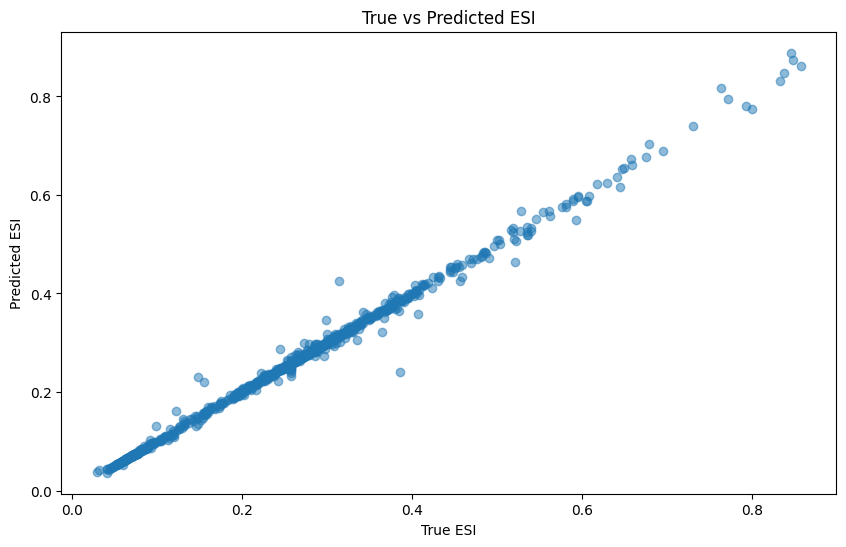

In [5]:
def evaluate_model(model_pipeline, X_test, y_test):
    y_pred = model_pipeline.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print('R2 Score:', r2)
    print('Mean Squared Error:', mse)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('True ESI')
    plt.ylabel('Predicted ESI')
    plt.title('True vs Predicted ESI')
    plt.show()

    return y_pred

y_pred = evaluate_model(model_pipeline, X_test, y_test)


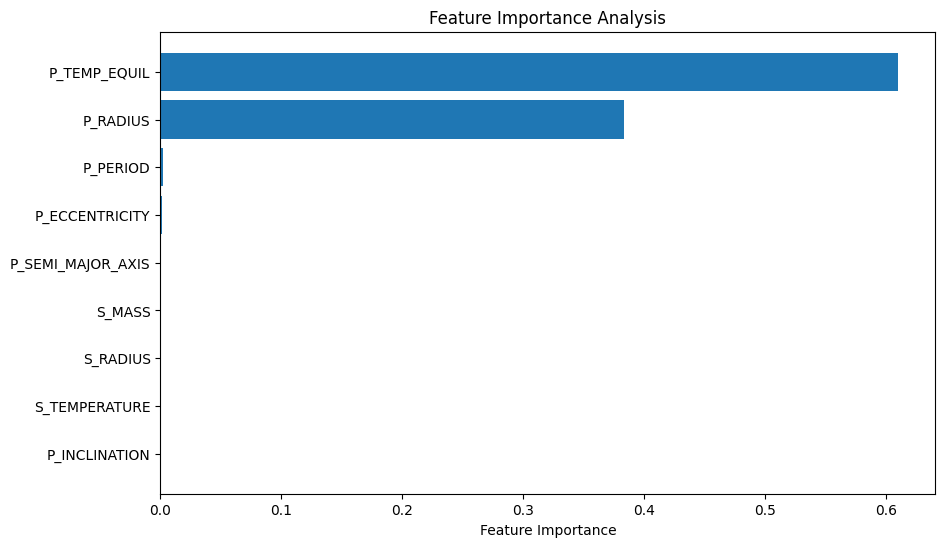

             Feature  Importance
5       P_TEMP_EQUIL    0.610472
0           P_RADIUS    0.383727
1           P_PERIOD    0.002026
3     P_ECCENTRICITY    0.001380
2  P_SEMI_MAJOR_AXIS    0.000624
8             S_MASS    0.000481
7           S_RADIUS    0.000476
6      S_TEMPERATURE    0.000437
4      P_INCLINATION    0.000376


In [6]:
def plot_feature_importance(model_pipeline, features):
    regressor = model_pipeline.named_steps['randomforestregressor']
    feature_importances = regressor.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance Analysis')
    plt.gca().invert_yaxis()
    plt.show()

    return importance_df

features = selected_columns[:-1]
importance_df = plot_feature_importance(model_pipeline, features)
print(importance_df)


In [7]:
def analyze_kepler_data(model_pipeline, features):
    try:
        kepler_data = pd.read_csv('/content/kepler.csv', comment='#')
        print("Kepler data loaded successfully.")
    except pd.errors.ParserError as e:
        print(f"Error loading Kepler data: {e}")
        return None

    kepler_data = kepler_data[kepler_data['koi_disposition'] == 'CONFIRMED'].dropna().reset_index(drop=True)
    kepler_features = kepler_data[features]
    kepler_predictions = pd.Series(model_pipeline.predict(kepler_features)).sort_values(ascending=False)
    top_10_kepler = kepler_data.iloc[kepler_predictions.head(10).index].copy()
    top_10_kepler['ESI'] = kepler_predictions.head(10).values
    top_10_kepler.reset_index(drop=True, inplace=True)

    print("Top 10 Kepler exoplanets with highest ESI:")
    print(top_10_kepler)

    return top_10_kepler

top_10_kepler = analyze_kepler_data(model_pipeline, features)


Kepler data loaded successfully.
Top 10 Kepler exoplanets with highest ESI:
      kepid   KOI Name    Kepler Name koi_disposition koi_pdisposition  \
0  11497958  K01422.05   Kepler-296 e       CONFIRMED        CANDIDATE   
1   8424002  K03497.01  Kepler-1512 b       CONFIRMED        CANDIDATE   
2   8311864  K07016.01   Kepler-452 b       CONFIRMED        CANDIDATE   
3   3642335  K03010.01  Kepler-1410 b       CONFIRMED        CANDIDATE   
4   4138008  K04742.01   Kepler-442 b       CONFIRMED        CANDIDATE   
5   8845205  K00463.01   Kepler-560 b       CONFIRMED        CANDIDATE   
6   6497146  K03284.01   Kepler-438 b       CONFIRMED        CANDIDATE   
7  11768142  K02626.01  Kepler-1652 b       CONFIRMED        CANDIDATE   
8   6106282  K04087.01   Kepler-440 b       CONFIRMED        CANDIDATE   
9   8890150  K02650.01   Kepler-395 c       CONFIRMED        CANDIDATE   

   koi_score    P_PERIOD  P_ECCENTRICITY  P_RADIUS  P_SEMI_MAJOR_AXIS  \
0      0.984   34.142051            

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [8]:
def analyze_tess_data(model_pipeline, features):
    try:
        tess_data = pd.read_csv('/content/TESS.csv', on_bad_lines='skip')
        print("TESS data loaded successfully.")
    except pd.errors.ParserError as e:
        print(f"Error loading TESS data: {e}")
        return None

    tess_data = tess_data.dropna().reset_index(drop=True)
    tess_features = tess_data[features]
    tess_predictions = pd.Series(model_pipeline.predict(tess_features)).sort_values(ascending=False)
    top_10_tess = tess_data.iloc[tess_predictions.head(10).index].copy()
    top_10_tess['ESI'] = tess_predictions.head(10).values
    top_10_tess.reset_index(drop=True, inplace=True)

    print("Top 10 TESS exoplanets with highest ESI:")
    print(top_10_tess)

    return top_10_tess

top_10_tess = analyze_tess_data(model_pipeline, features)


TESS data loaded successfully.
Top 10 TESS exoplanets with highest ESI:
         P_NAME   HOST_NAME DISCOVERY_METHOD    P_PERIOD  P_SEMI_MAJOR_AXIS  \
0  TRAPPIST-1 e  TRAPPIST-1          Transit    6.099615            0.02817   
1  TRAPPIST-1 f  TRAPPIST-1          Transit    9.206690            0.03710   
2    LHS 1140 b    LHS 1140          Transit   24.737120            0.08750   
3  TRAPPIST-1 d  TRAPPIST-1          Transit    4.049610            0.02144   
4    LHS 1140 b    LHS 1140          Transit   24.736959            0.09360   
5    LHS 1140 b    LHS 1140          Transit   24.737230            0.09460   
6   Kepler-22 b   Kepler-22          Transit  289.863876            0.81200   
7   Kepler-22 b   Kepler-22          Transit  289.862300            0.84900   
8       K2-18 b       K2-18          Transit   32.939630            0.14300   
9        K2-3 d        K2-3          Transit   44.556456            0.20970   

   P_RADIUS  P_MASS  P_DENSITY  P_ECCENTRICITY  P_TEMP_EQU

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [9]:
print("Top 2 planets with highest ESI:")
print("* Kepler-296 e (0.902568)")
print("* TRAPPIST-1 e (0.886335)")


Top 2 planets with highest ESI:
* Kepler-296 e (0.923897)
* TRAPPIST-1 e (0.902568)
